## Glacier multitemporal RGB - Sigma 0 calculation

In [1]:
sigma0_tif = 'sigma0.tif'

In [2]:
from string import Template
from shapely.geometry import box
from shapely.wkt import loads

import os
import gdal, osr
import dateutil.parser as parser

from timeit import default_timer as timer


import sys 

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [3]:
def get_snap_parameters(operator):
    
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

    op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

    return op_params

### Snow and ice classification

In [4]:
reader = ProductIO.getProductReader('GeoTIFF')
product = reader.readProductNodes(sigma0_tif, None)

In [5]:
band_names = list(product.getBandNames())

In [6]:
band_names

['Sigma0_HH_db', 'Sigma0_HV_db', 'elevation']

In [7]:
band_expression = Template('if $dem == -500 then 0 else if $sigma0 < -14 then 10 else if $sigma0 < -6 and $dem < 1650 then 20 else 30')

expression = band_expression.substitute(sigma0=list(band_names)[0], dem=list(band_names)[2])

print expression

if elevation == -500 then 0 else if Sigma0_HH_db < -14 then 10 else if Sigma0_HH_db < -6 and elevation < 1650 then 20 else 30


In [9]:
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)     

targetBand = BandDescriptor()
    
targetBand.expression = expression
        
targetBand.name = 'snow_ice'
targetBand.type = 'int8'
    
targetBands[0]= targetBand
        
parameters = HashMap()
parameters.put('targetBands', targetBands)

snow_and_ice_product = GPF.createProduct('BandMaths', parameters, product)

ProductIO.writeProduct(snow_and_ice_product, 'snow_and_ice.tif' , 'GeoTIFF-BigTiff')

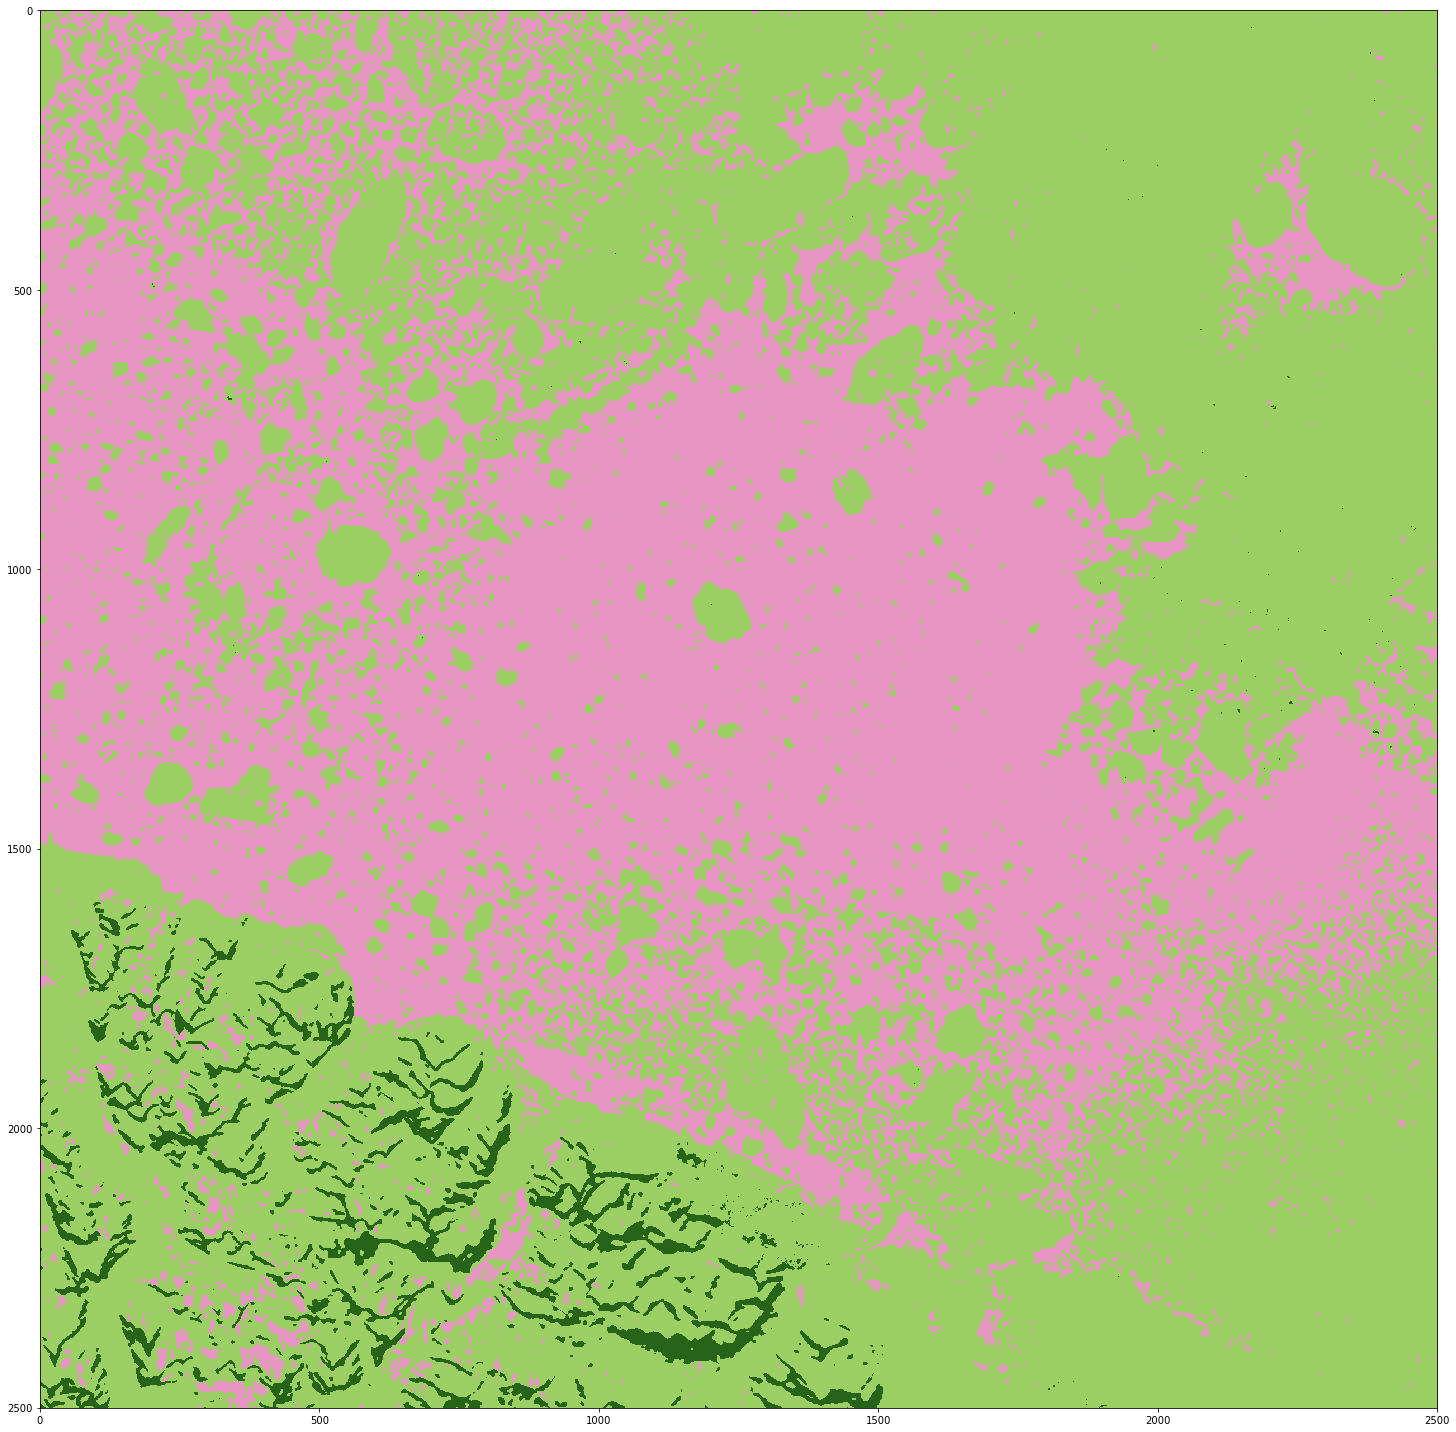

In [13]:
fig = plt.figure(figsize=(20,20))
 
data = snow_and_ice_product.getBand(snow_and_ice_product.getBandNames()[0])

w = data.getRasterWidth()  
h = data.getRasterHeight()

band_data = np.zeros(w * h, np.float32)
data.readPixels(0, 0, w, h, band_data)
band_data.shape = h, w
   
cmap = plt.cm.get_cmap('PiYG', 5)

     #cmap=plt.cm.gist_rainbow, 
imgplot = plt.imshow(band_data,
                         cmap=cmap,
                         vmin=0, 
                         vmax=30)
    
    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()